In [4]:
!pip install kagglehub

In [5]:
from collections import Counter
import os
import random
import yaml

import kagglehub
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns

In [6]:
# Descargar dataset
path = kagglehub.dataset_download("orvile/x-ray-baggage-anomaly-detection")

print("Path del dataset:", path)

100%|██████████| 133M/133M [00:01<00:00, 73.2MB/s]

Extracting files...


Path del dataset: /root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1


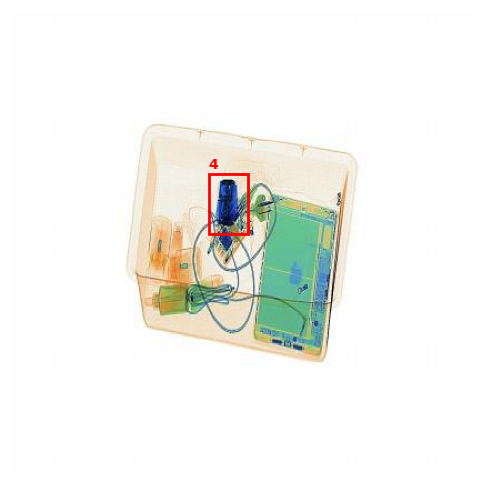

In [7]:
# Definir paths (ajustar a tu ruta base)
base_path = path  # donde kagglehub descargó
images_path = os.path.join(base_path, "train", "images")
labels_path = os.path.join(base_path, "train", "labels")

# Cargar clases desde data.yaml (si querés tener nombres)
with open(os.path.join(base_path, "data.yaml"), "r") as f:
    classes = yaml.safe_load(f)["names"]

# Elegir imagen al azar
img_file = random.choice(os.listdir(images_path))
img_path = os.path.join(images_path, img_file)
label_path = os.path.join(labels_path, img_file.replace(".jpg", ".txt"))

# Abrir imagen
img = Image.open(img_path).convert("RGB")
w, h = img.size

# Dibujar imagen
fig, ax = plt.subplots(1, figsize=(6,6))
ax.imshow(img)

# Cargar labels YOLO (clase x_center y_center width height)
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())
            cls = int(cls)

            # convertir coordenadas YOLO a pixeles
            x_center, y_center = x * w, y * h
            bw, bh = bw * w, bh * h
            x1 = x_center - bw/2
            y1 = y_center - bh/2

            # dibujar rectángulo
            rect = patches.Rectangle((x1, y1), bw, bh, linewidth=2,
                                     edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.text(x1, y1-5, classes[cls], color="red", fontsize=10, weight="bold")

plt.axis("off")
plt.show()

## **Distribución de clases**

In [8]:
# Función para cargar etiquetas y crear un DataFrame
def load_labels(label_dir, split_name):
    data = []
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(label_dir.replace('labels', 'images'), image_file)
            with open(os.path.join(label_dir, label_file), 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])
                    data.append([split_name, image_path, class_id, x_center_norm, y_center_norm, width_norm, height_norm])
    return pd.DataFrame(data, columns=['split', 'image_path', 'class_id', 'x_center_norm', 'y_center_norm', 'width_norm', 'height_norm'])

# Cargar datos para cada split
df_train = load_labels(os.path.join(base_path, "train", "labels"), "train")
df_valid = load_labels(os.path.join(base_path, "valid", "labels"), "valid")
df_test = load_labels(os.path.join(base_path, "test", "labels"), "test")

# Concatenar dataframes
df_all = pd.concat([df_train, df_valid, df_test], ignore_index=True)

# Agregar nombres de clases (asumiendo que la lista 'classes' está disponible de la celda anterior)
df_all['class_name'] = df_all['class_id'].apply(lambda x: classes[x] if x < len(classes) else f'Unknown_{x}')

print(f"Total de imágenes: {sum(df_all['class_name'].value_counts())}")
# Mostrar la distribución de clases
print("\nDistribución de clases:")
display(df_all['class_name'].value_counts().sort_index())

print("\nDistribución de clases por split:")
display(df_all.groupby('split')['class_name'].value_counts().unstack(fill_value=0))

Total de imágenes: 8830

Distribución de clases:


class_name
0    1841
1    1975
2    1041
3    1948
4    2025
Name: count, dtype: int64


Distribución de clases por split:


class_name     0     1    2     3     4
split                                  
test         166   193  118   203   203
train       1284  1393  698  1379  1427
valid        391   389  225   366   395

## **Dimensión de imágenes y relación de aspecto**

In [9]:
# Directorios de train y validation
splits = [
    os.path.join(base_path, "train", "images"),
    os.path.join(base_path, "test", "images"),
    os.path.join(base_path, "valid", "images")
]

# Contador de tamaños y canales
sizes_counter = Counter()
channels_counter = Counter()

for split_path in splits:
    for img_name in os.listdir(split_path):
        img_path = os.path.join(split_path, img_name)
        try:
            with Image.open(img_path) as img:
                sizes_counter[img.size] += 1  # (width, height)
                channels_counter[len(img.getbands())] += 1  # nº canales
        except Exception as e:
            print(f"Error al leer {img_path}: {e}")

print("=== Tamaños de imágenes (width x height) ===")
for size, count in sizes_counter.most_common():
    print(f"{size}: {count}")

print("\n=== Número de canales ===")
for ch, count in channels_counter.items():
    label = "Grises" if ch == 1 else "RGB" if ch == 3 else "Otro"
    print(f"{ch} canales ({label}): {count}")

=== Tamaños de imágenes (width x height) ===
(416, 416): 8830

=== Número de canales ===
3 canales (RGB): 8830


La relación de aspecto es 1 porque todas las imágenes son cuadradas (416x416 píxeles).

## **Distribución de bounding boxes**

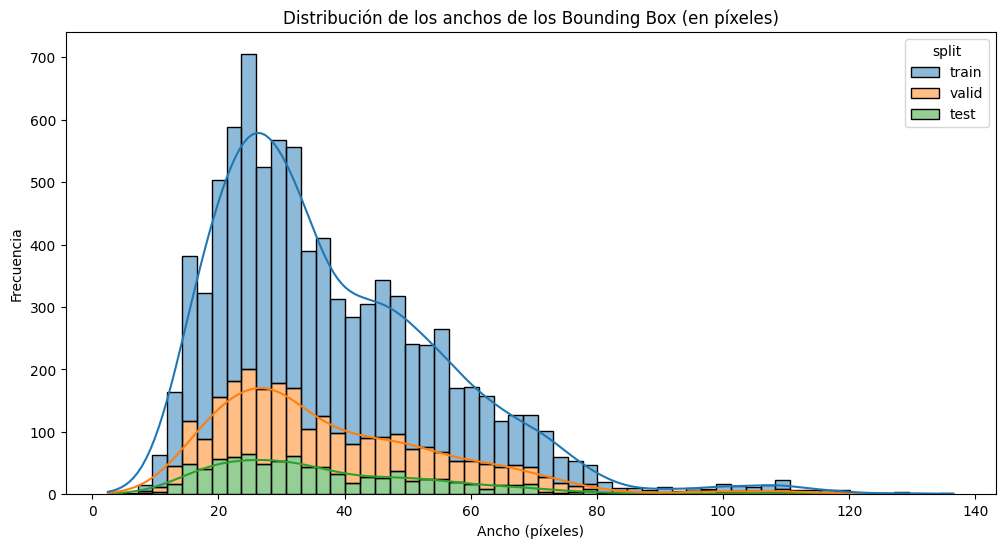

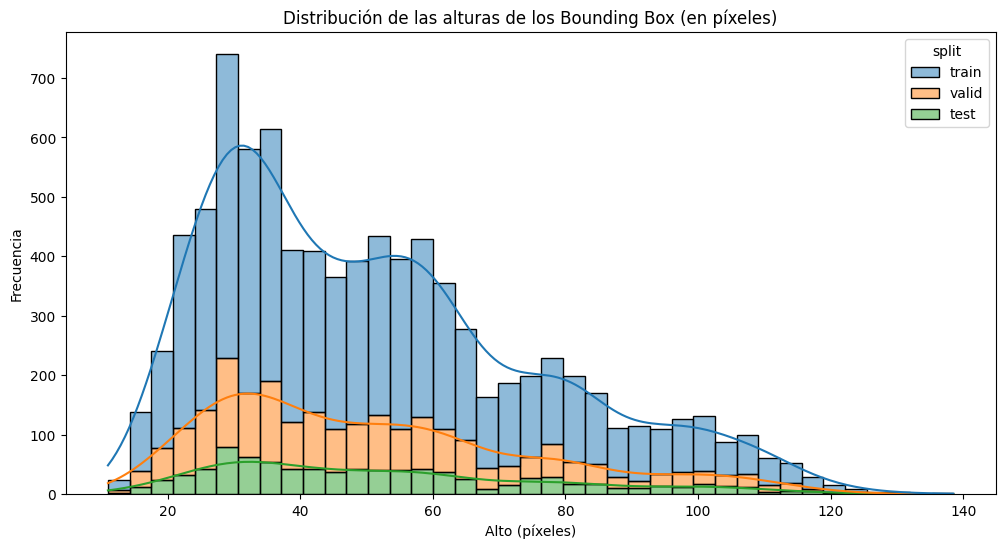

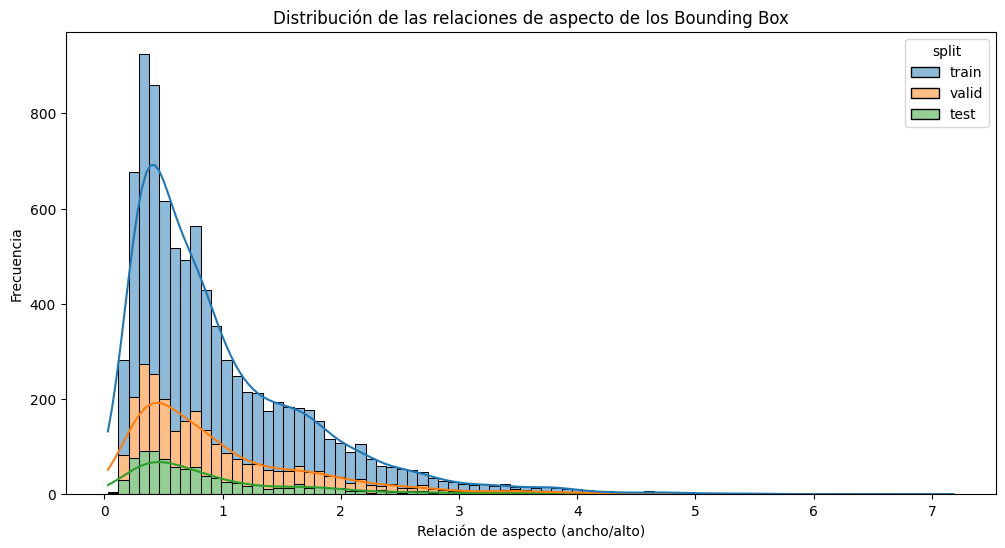

In [10]:
# Analizar las dimensiones de las cajas delimitadoras (ancho y alto)
df_all['width_pixels'] = df_all['width_norm'] * df_all['image_path'].apply(lambda x: Image.open(x).size[0])
df_all['height_pixels'] = df_all['height_norm'] * df_all['image_path'].apply(lambda x: Image.open(x).size[1])

plt.figure(figsize=(12, 6))
sns.histplot(df_all, x='width_pixels', hue='split', kde=True, multiple="stack")
plt.title('Distribución de los anchos de los Bounding Box (en píxeles)')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_all, x='height_pixels', hue='split', kde=True, multiple="stack")
plt.title('Distribución de las alturas de los Bounding Box (en píxeles)')
plt.xlabel('Alto (píxeles)')
plt.ylabel('Frecuencia')
plt.show()

# Analyze bounding box aspect ratio
df_all['aspect_ratio'] = df_all['width_pixels'] / df_all['height_pixels']

plt.figure(figsize=(12, 6))
sns.histplot(df_all, x='aspect_ratio', hue='split', kde=True, multiple="stack")
plt.title('Distribución de las relaciones de aspecto de los Bounding Box')
plt.xlabel('Relación de aspecto (ancho/alto)')
plt.ylabel('Frecuencia')
plt.show()

* Los histogramas de ancho y alto de las bounding boxes en píxeles muestran que la mayoría de las cajas son relativamente pequeñas en comparación con las dimensiones de la imagen completa.
* La distribución de la relación de aspecto de las bounding boxes indica una variedad de formas, con un pico alrededor de 1, lo que sugiere que hay muchos objetos con una relación de aspecto cercana a cuadrada.

## **Calidad de imágenes**

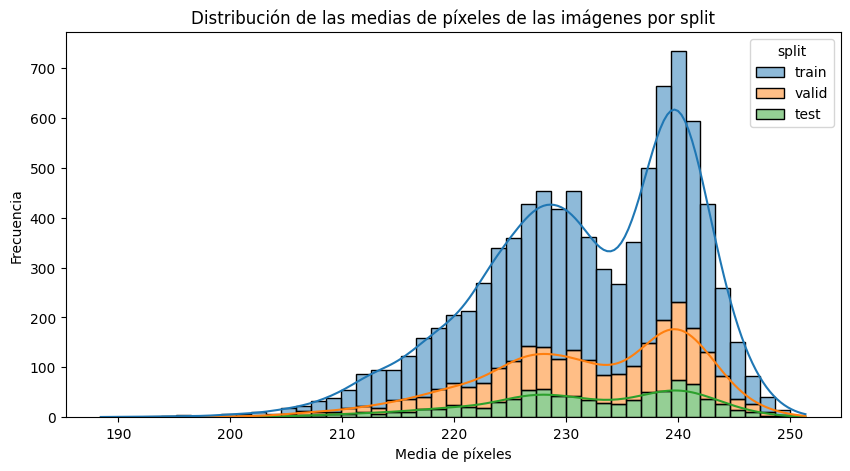

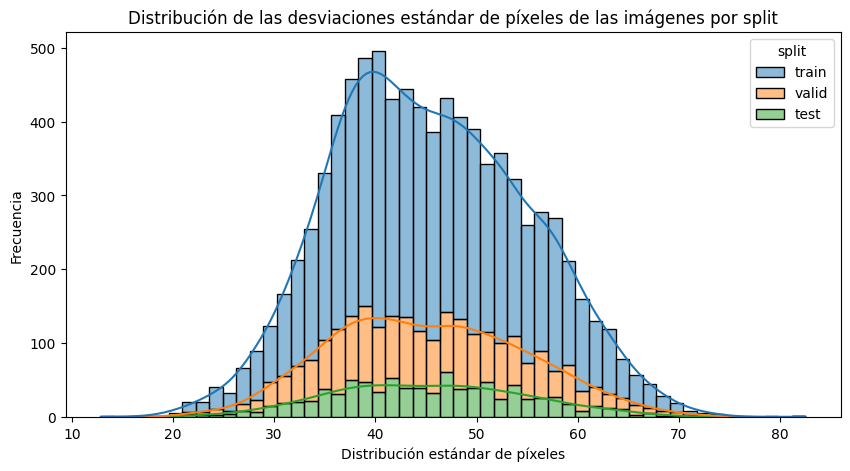

In [11]:
# Calcular la media y la desviación estándar de los valores de píxeles por división
pixel_data = []

for split_name in ["train", "valid", "test"]:
    split_images_path = os.path.join(base_path, split_name, "images")
    for img_file in os.listdir(split_images_path):
        img_path = os.path.join(split_images_path, img_file)
        img = Image.open(img_path).convert("RGB")
        img_array = np.array(img)

        pixel_data.append([split_name, np.mean(img_array), np.std(img_array)])

df_pixel_data = pd.DataFrame(pixel_data, columns=['split', 'pixel_mean', 'pixel_std'])

plt.figure(figsize=(10, 5))
sns.histplot(data=df_pixel_data, x='pixel_mean', hue='split', kde=True, multiple="stack")
plt.title('Distribución de las medias de píxeles de las imágenes por split')
plt.xlabel('Media de píxeles')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=df_pixel_data, x='pixel_std', hue='split', kde=True, multiple="stack")
plt.title('Distribución de las desviaciones estándar de píxeles de las imágenes por split')
plt.xlabel('Distribución estándar de píxeles')
plt.ylabel('Frecuencia')
plt.show()

Los histogramas de la media y desviación estándar de los píxeles proporcionan información sobre el brillo general y el contraste de las imágenes. La distribución de la media de píxeles muestra dos picos, lo que podría indicar diferentes condiciones de iluminación o tipos de contenido en las imágenes. La desviación estándar de los píxeles sugiere una variabilidad moderada en el contraste

## **Ejemplos de imágenes con anotaciones**

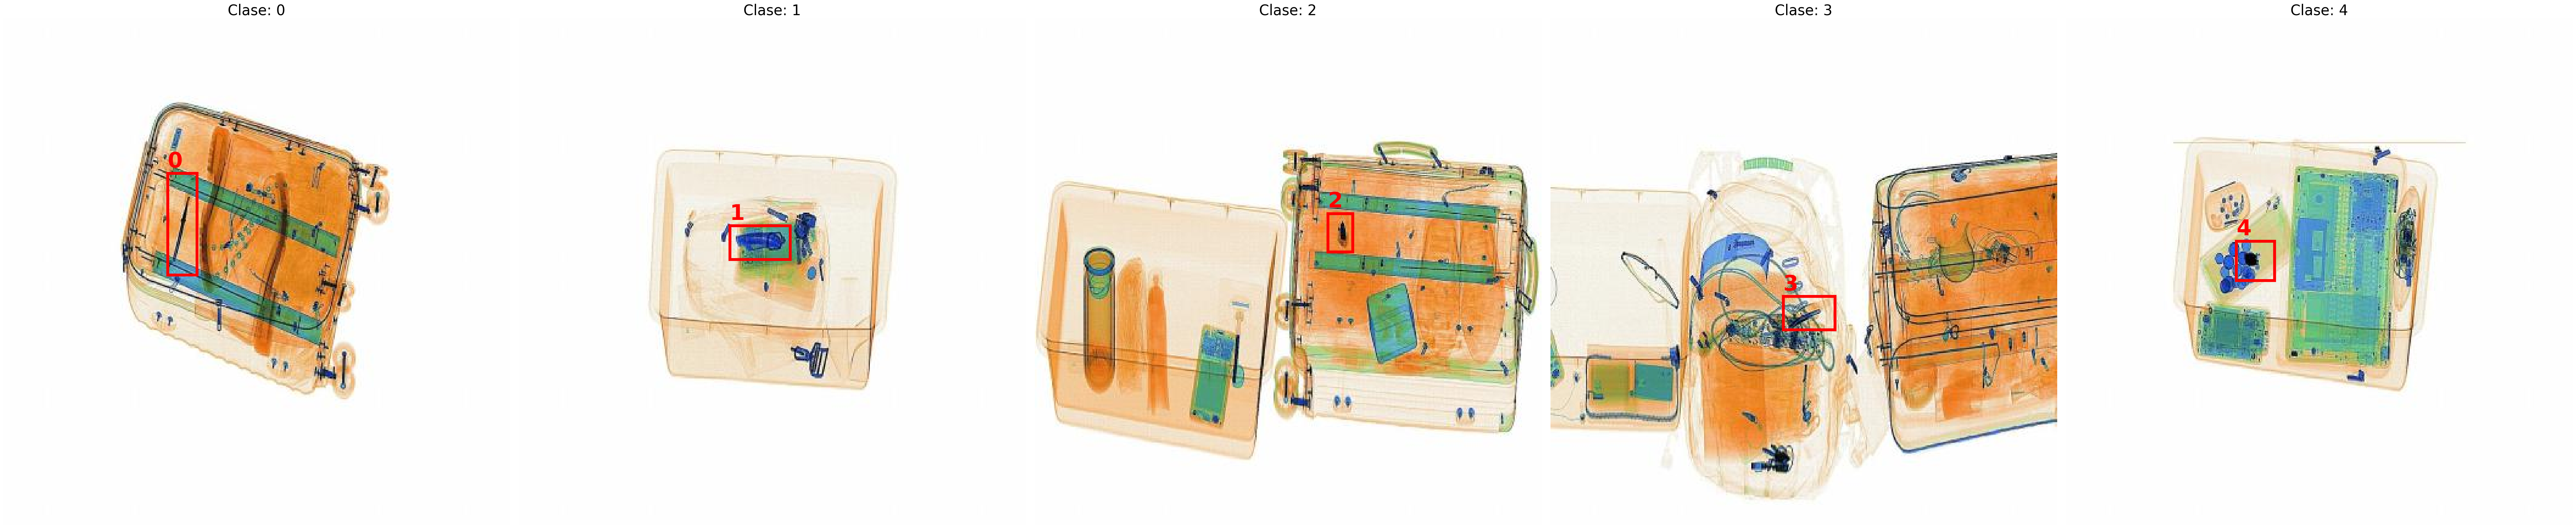

In [12]:
# Mostrar una imagen por cada clase con anotaciones
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Obtener una lista de archivos de imagen
image_files = os.listdir(images_path)

# Buscar una imagen para cada clase
images_by_class = {}
for img_file in image_files:
    img_path = os.path.join(images_path, img_file)
    label_path = os.path.join(labels_path, img_file.replace(".jpg", ".txt"))

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls = int(line.strip().split()[0])
                if cls not in images_by_class:
                    images_by_class[cls] = img_file
                    break # Encontramos una imagen para esta clase, pasamos a la siguiente

# Crear una figura para cada clase encontrada
num_classes_found = len(images_by_class)
fig, axes = plt.subplots(1, num_classes_found, figsize=(15 * num_classes_found, 15))

for i, cls in enumerate(sorted(images_by_class.keys())):
    img_file = images_by_class[cls]
    img_path = os.path.join(images_path, img_file)
    label_path = os.path.join(labels_path, img_file.replace(".jpg", ".txt"))

    # Abrir imagen
    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    # Dibujar imagen
    ax = axes[i] if num_classes_found > 1 else axes
    ax.imshow(img)

    # Cargar y dibujar los labels de YOLO para la clase seleccionada
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls_id = int(parts[0])
                if cls_id == cls: # Dibujar solo los bounding boxes de la clase actual
                    x, y, bw, bh = map(float, parts[1:])

                    # Convertir coordenadas YOLO a píxeles
                    x_center, y_center = x * w, y * h
                    bw, bh = bw * w, bh * h
                    x1 = x_center - bw/2
                    y1 = y_center - bh/2

                    # Dibujar rectángulo
                    rect = patches.Rectangle((x1, y1), bw, bh, linewidth=6,
                                             edgecolor="red", facecolor="none")
                    ax.add_patch(rect)
                    ax.text(x1, y1-5, classes[cls_id], color="red", fontsize=45, weight="bold")

    ax.axis("off")
    ax.set_title(f"Clase: {classes[cls]}", fontdict={"fontsize": 30})

plt.tight_layout()
plt.show()

## Implementación y entrenamiento de un modelo YOLOv8

## Instalar ultralytics yolo


In [13]:
!pip install ultralytics

## Preparar la configuración del dataset


In [14]:
data_yaml_content = f"""
path: {base_path}
train: train/images
val: valid/images
test: test/images

nc: {len(classes)}
names: {classes}
"""

with open(os.path.join(base_path, "data.yaml"), "w") as f:
    f.write(data_yaml_content)

print("data.yaml creado exitosamente.")

data.yaml file created successfully.


## Entrenar el modelo yolov8


In [17]:
from ultralytics import YOLO

# Cargar un modelo YOLOv8n preentrenado
model = YOLO('yolov8n.pt')

# Entrenar el modelo en el conjunto de datos
results = model.train(data=os.path.join(base_path, "data.yaml"), epochs=10, imgsz=416)

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

El modelo YOLOv8 entrenado en el conjunto de datos de detección de anomalías en equipaje de rayos X muestra un rendimiento moderado en el conjunto de validación.

* El mAP50 de 0.5878 indica que el modelo es razonablemente bueno para detectar y localizar objetos con una superposición del 50% o más con la verdad fundamental. Esto sugiere que el modelo ha aprendido a identificar la presencia de objetos en las imágenes.
* Sin embargo, el mAP50-95 de 0.2315 es significativamente más bajo. Esto sugiere que el rendimiento del modelo disminuye considerablemente a medida que se requiere una mayor precisión en la localización de las cajas delimitadoras. Es posible que el modelo tenga dificultades para predecir las bounding boxes con alta exactitud.
* Las métricas de Precisión (P) y Recall (R) a nivel global (fila 'all') también respaldan esta conclusión. Una precisión de 0.563 significa que aproximadamente el 56.3% de las detecciones del modelo son correctas. Un Recall de 0.577 significa que el modelo detecta aproximadamente el 57.7% de los objetos reales presentes en las imágenes.

En general, el modelo es capaz de detectar una parte significativa de los objetos con una precisión aceptable, pero hay un margen considerable para mejorar, especialmente en la precisión de la localización de las bounding boxes.

## Evaluar el modelo entrenado


In [18]:
from ultralytics import YOLO

model = YOLO('runs/detect/train/weights/best.pt')

# Evaluar el modelo en el conjunto de validación
evaluation_results = model.val(data=os.path.join(base_path, "data.yaml"))

# Imprimir o mostrar las métricas de evaluación relevantes
print("Evaluación de resultados:")
print(f"  mAP50: {evaluation_results.results_dict['metrics/mAP50(B)']:.4f}")
print(f"  mAP50-95: {evaluation_results.results_dict['metrics/mAP50-95(B)']:.4f}")

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 916.2±391.0 MB/s, size: 20.0 KB)
val: Scanning /root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/valid/labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1766/1766 3.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 111/111 10.5it/s 10.5s
                   all       1766       1766      0.563      0.577      0.588      0.231
                     0        391        391      0.518      0.882      0.822      0.362
                     1        389        389      0.655      0.612      0.643      0.234
                     2        225        225      0.606      0.137      0.275     0.0743
                     3        366        366      0.515      0.432  

## Realizar inferencia con el modelo entrenado


In [19]:
from ultralytics import YOLO

model = YOLO('runs/detect/train/weights/best.pt')

# Seleccionar el directorio que contiene las imágenes para inferencia (imágenes de prueba)
inference_image_directory = os.path.join(base_path, "test", "images")

# Predicción de imágenes de test
inference_results = model.predict(source=inference_image_directory, save=True, imgsz=416, conf=0.25)


image 1/883 /root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/test/images/009008_jpg.rf.8f9d287571d5d48f46a87116a4a82d56.jpg: 416x416 (no detections), 8.2ms
image 2/883 /root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/test/images/009024_jpg.rf.6de3f50660b30e85323eb009190d7747.jpg: 416x416 (no detections), 5.8ms
image 3/883 /root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/test/images/009030_jpg.rf.c072eddbe5c4df12ba092a3fea353d7c.jpg: 416x416 (no detections), 5.8ms
image 4/883 /root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/test/images/009045_jpg.rf.73baf175ea33c52e85c53979fcc1cde0.jpg: 416x416 (no detections), 6.6ms
image 5/883 /root/.cache/kagglehub/datasets/orvile/x-ray-baggage-anomaly-detection/versions/1/test/images/009072_jpg.rf.ee449c968c7fbd052f338148998aff10.jpg: 416x416 (no detections), 5.9ms
image 6/883 /root/.cache/kagglehub/datasets/orvile/x-r

## Visualizar resultados de la inferencia


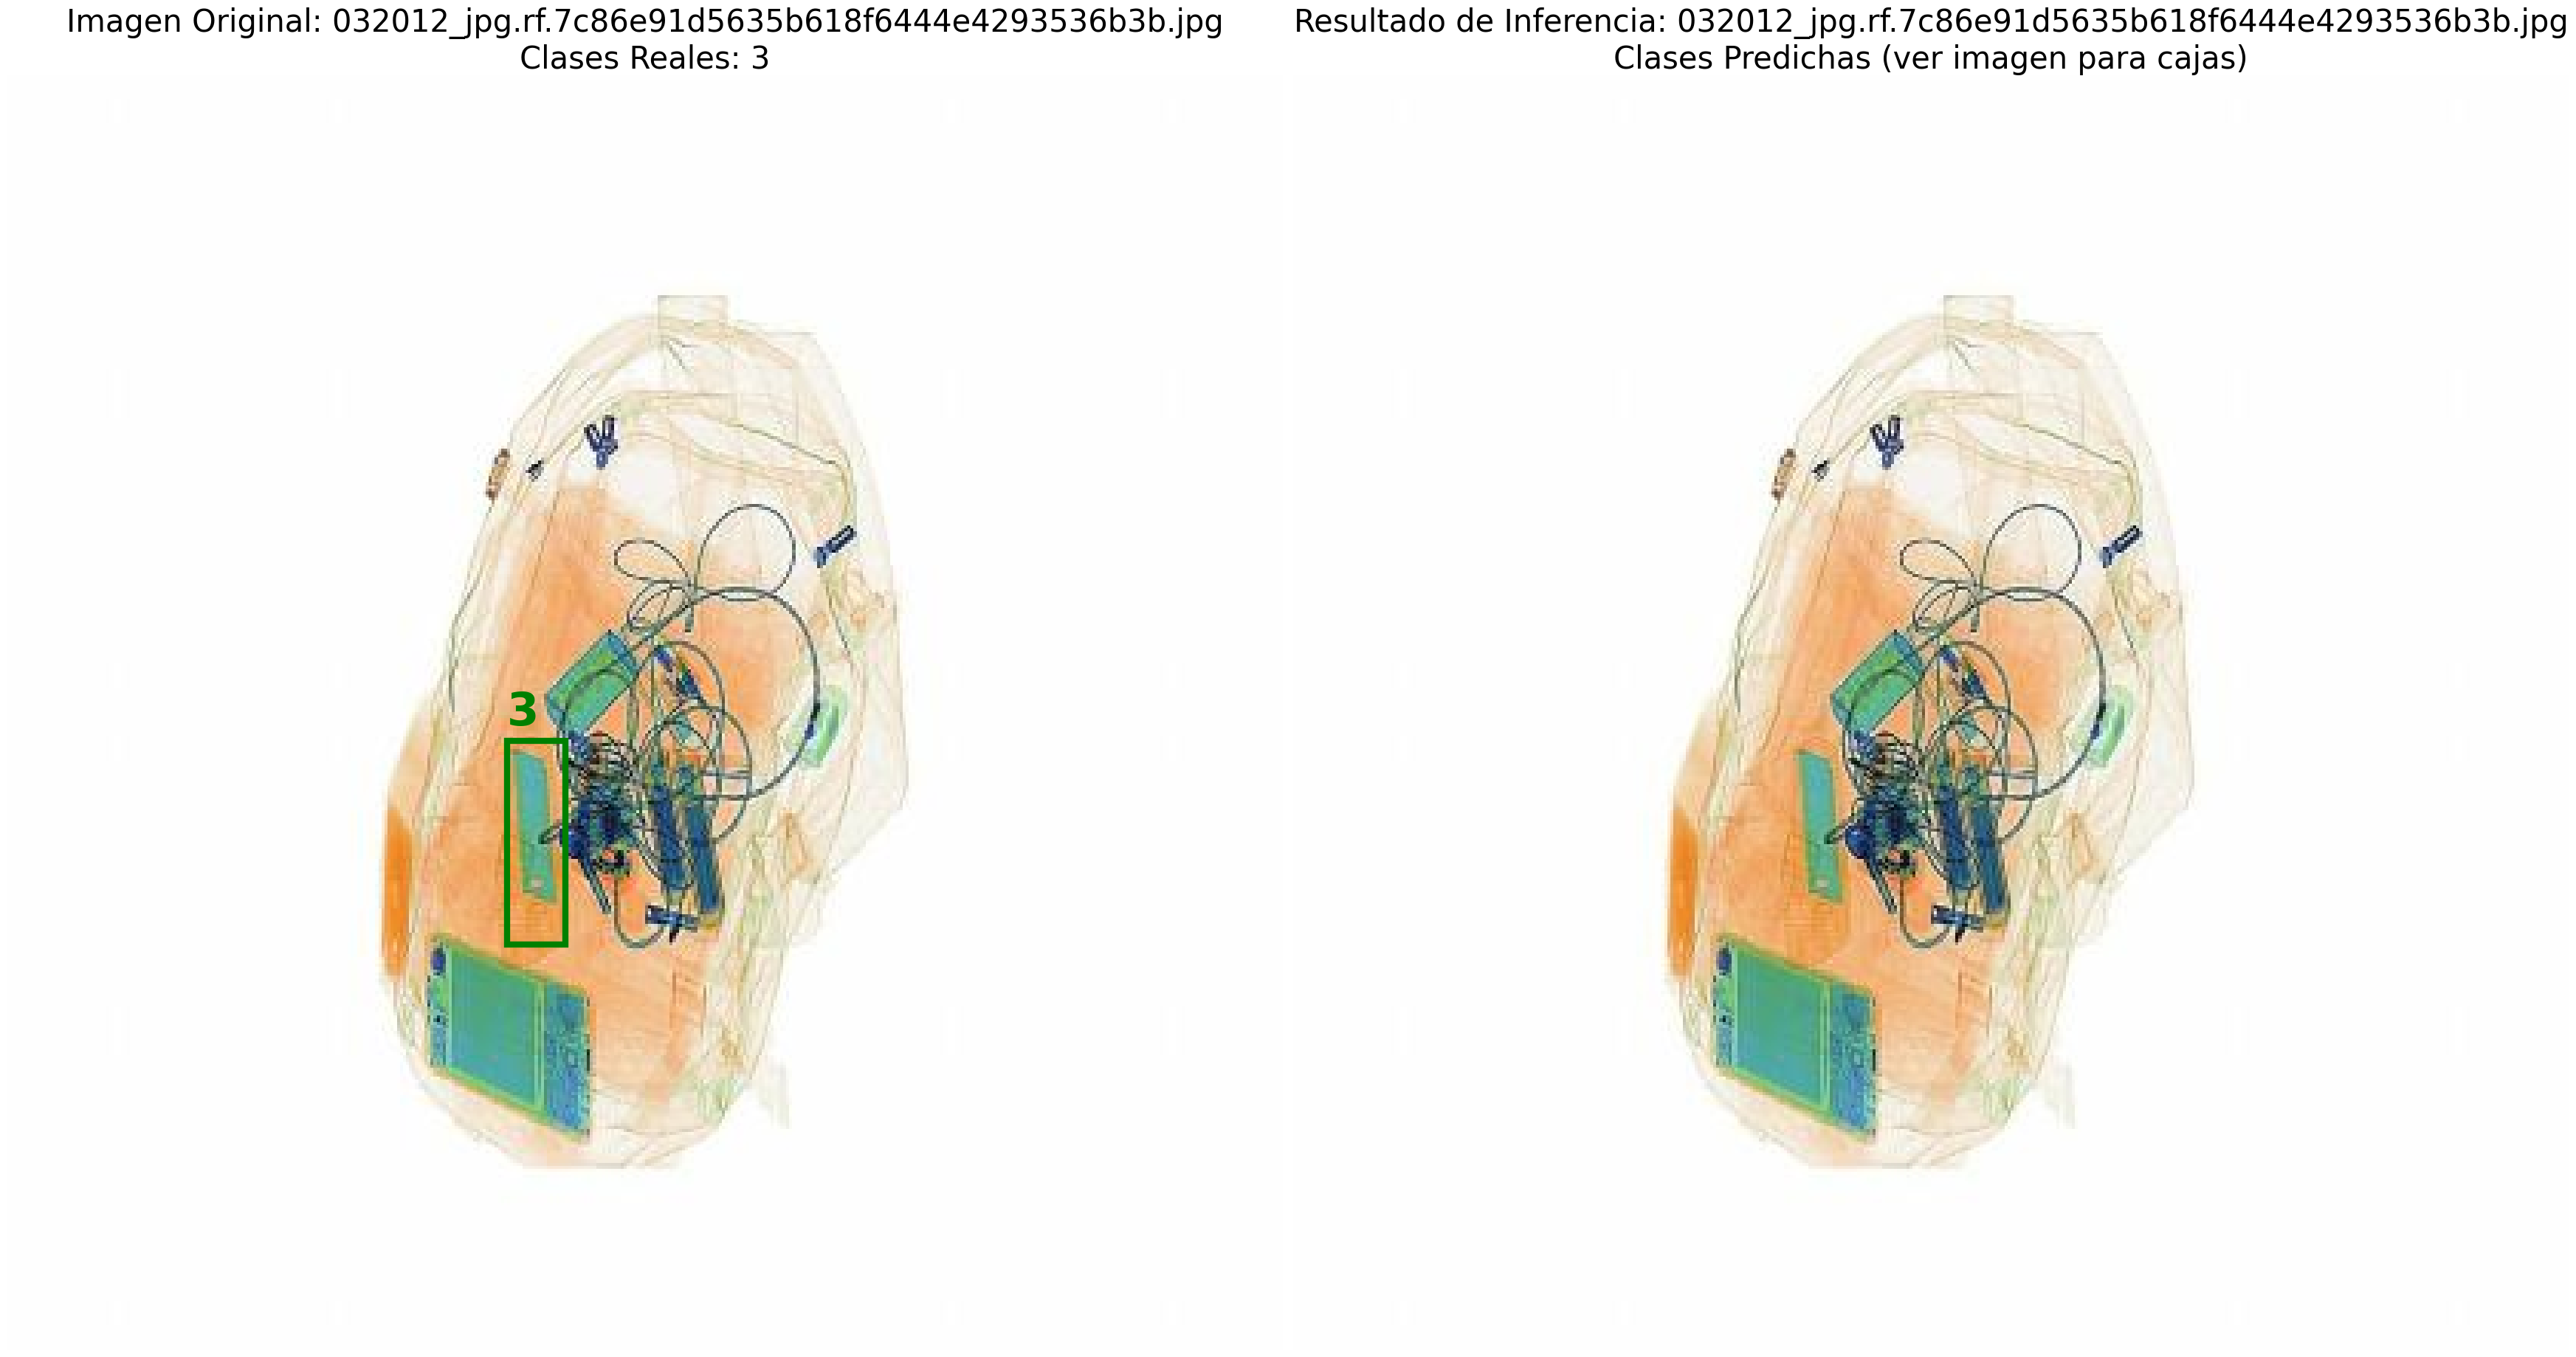

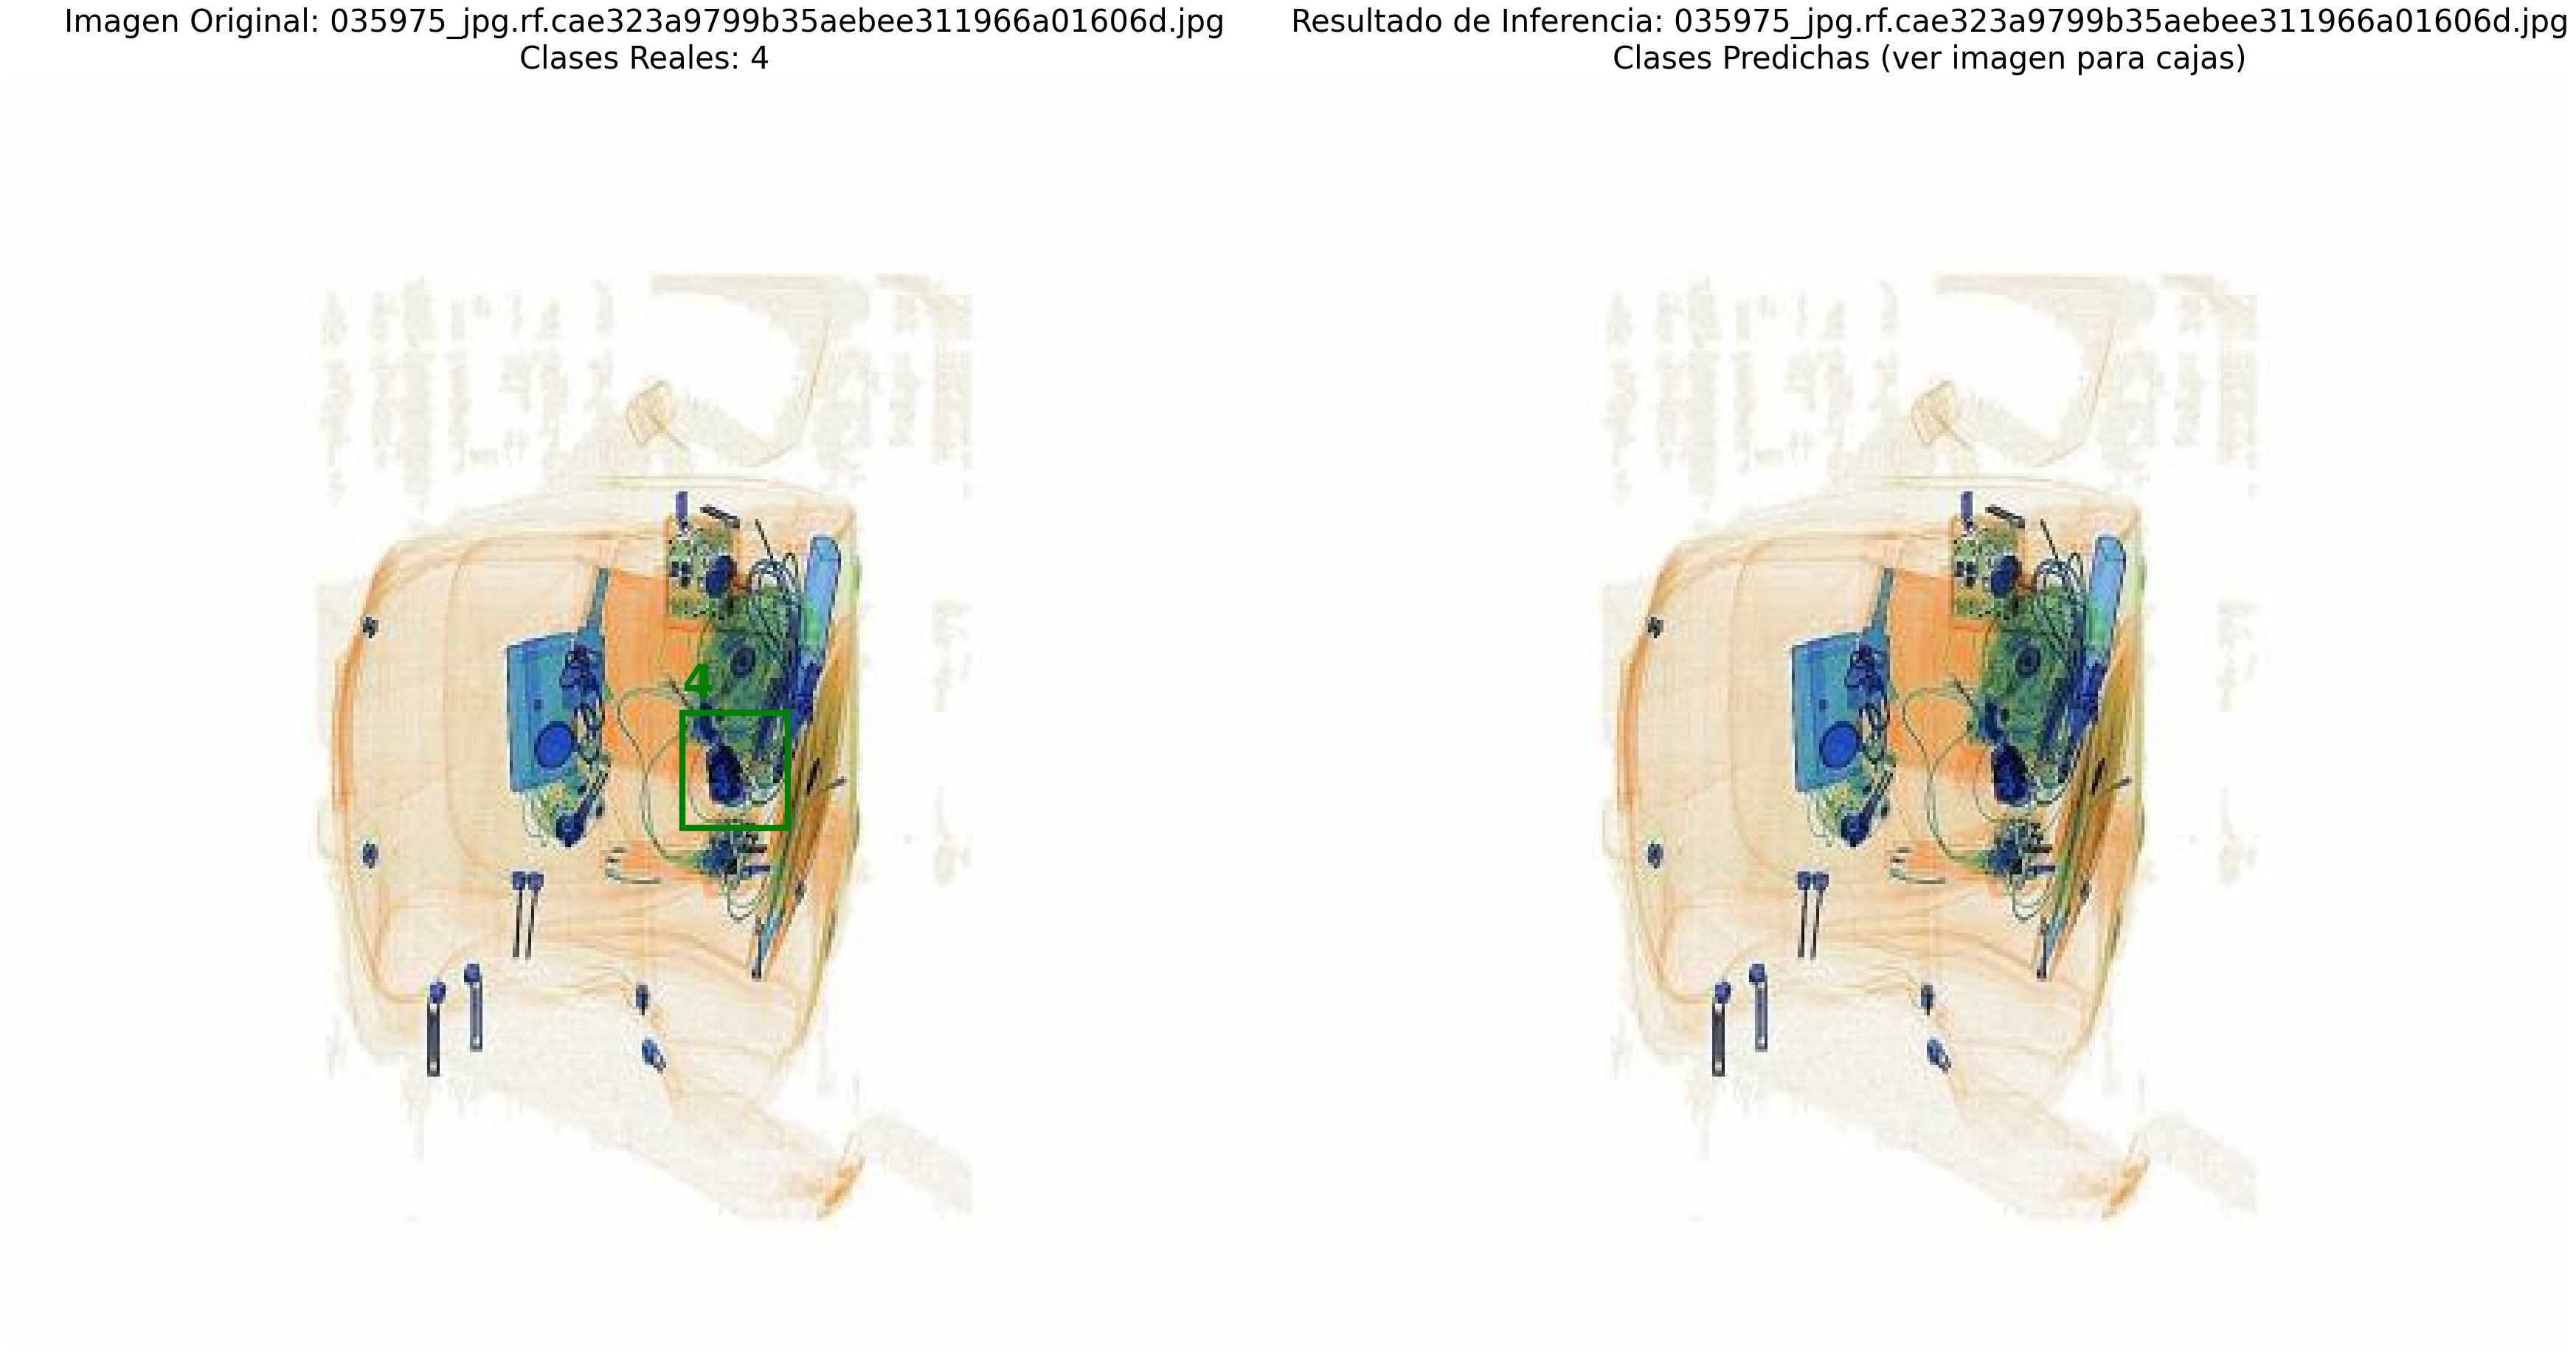

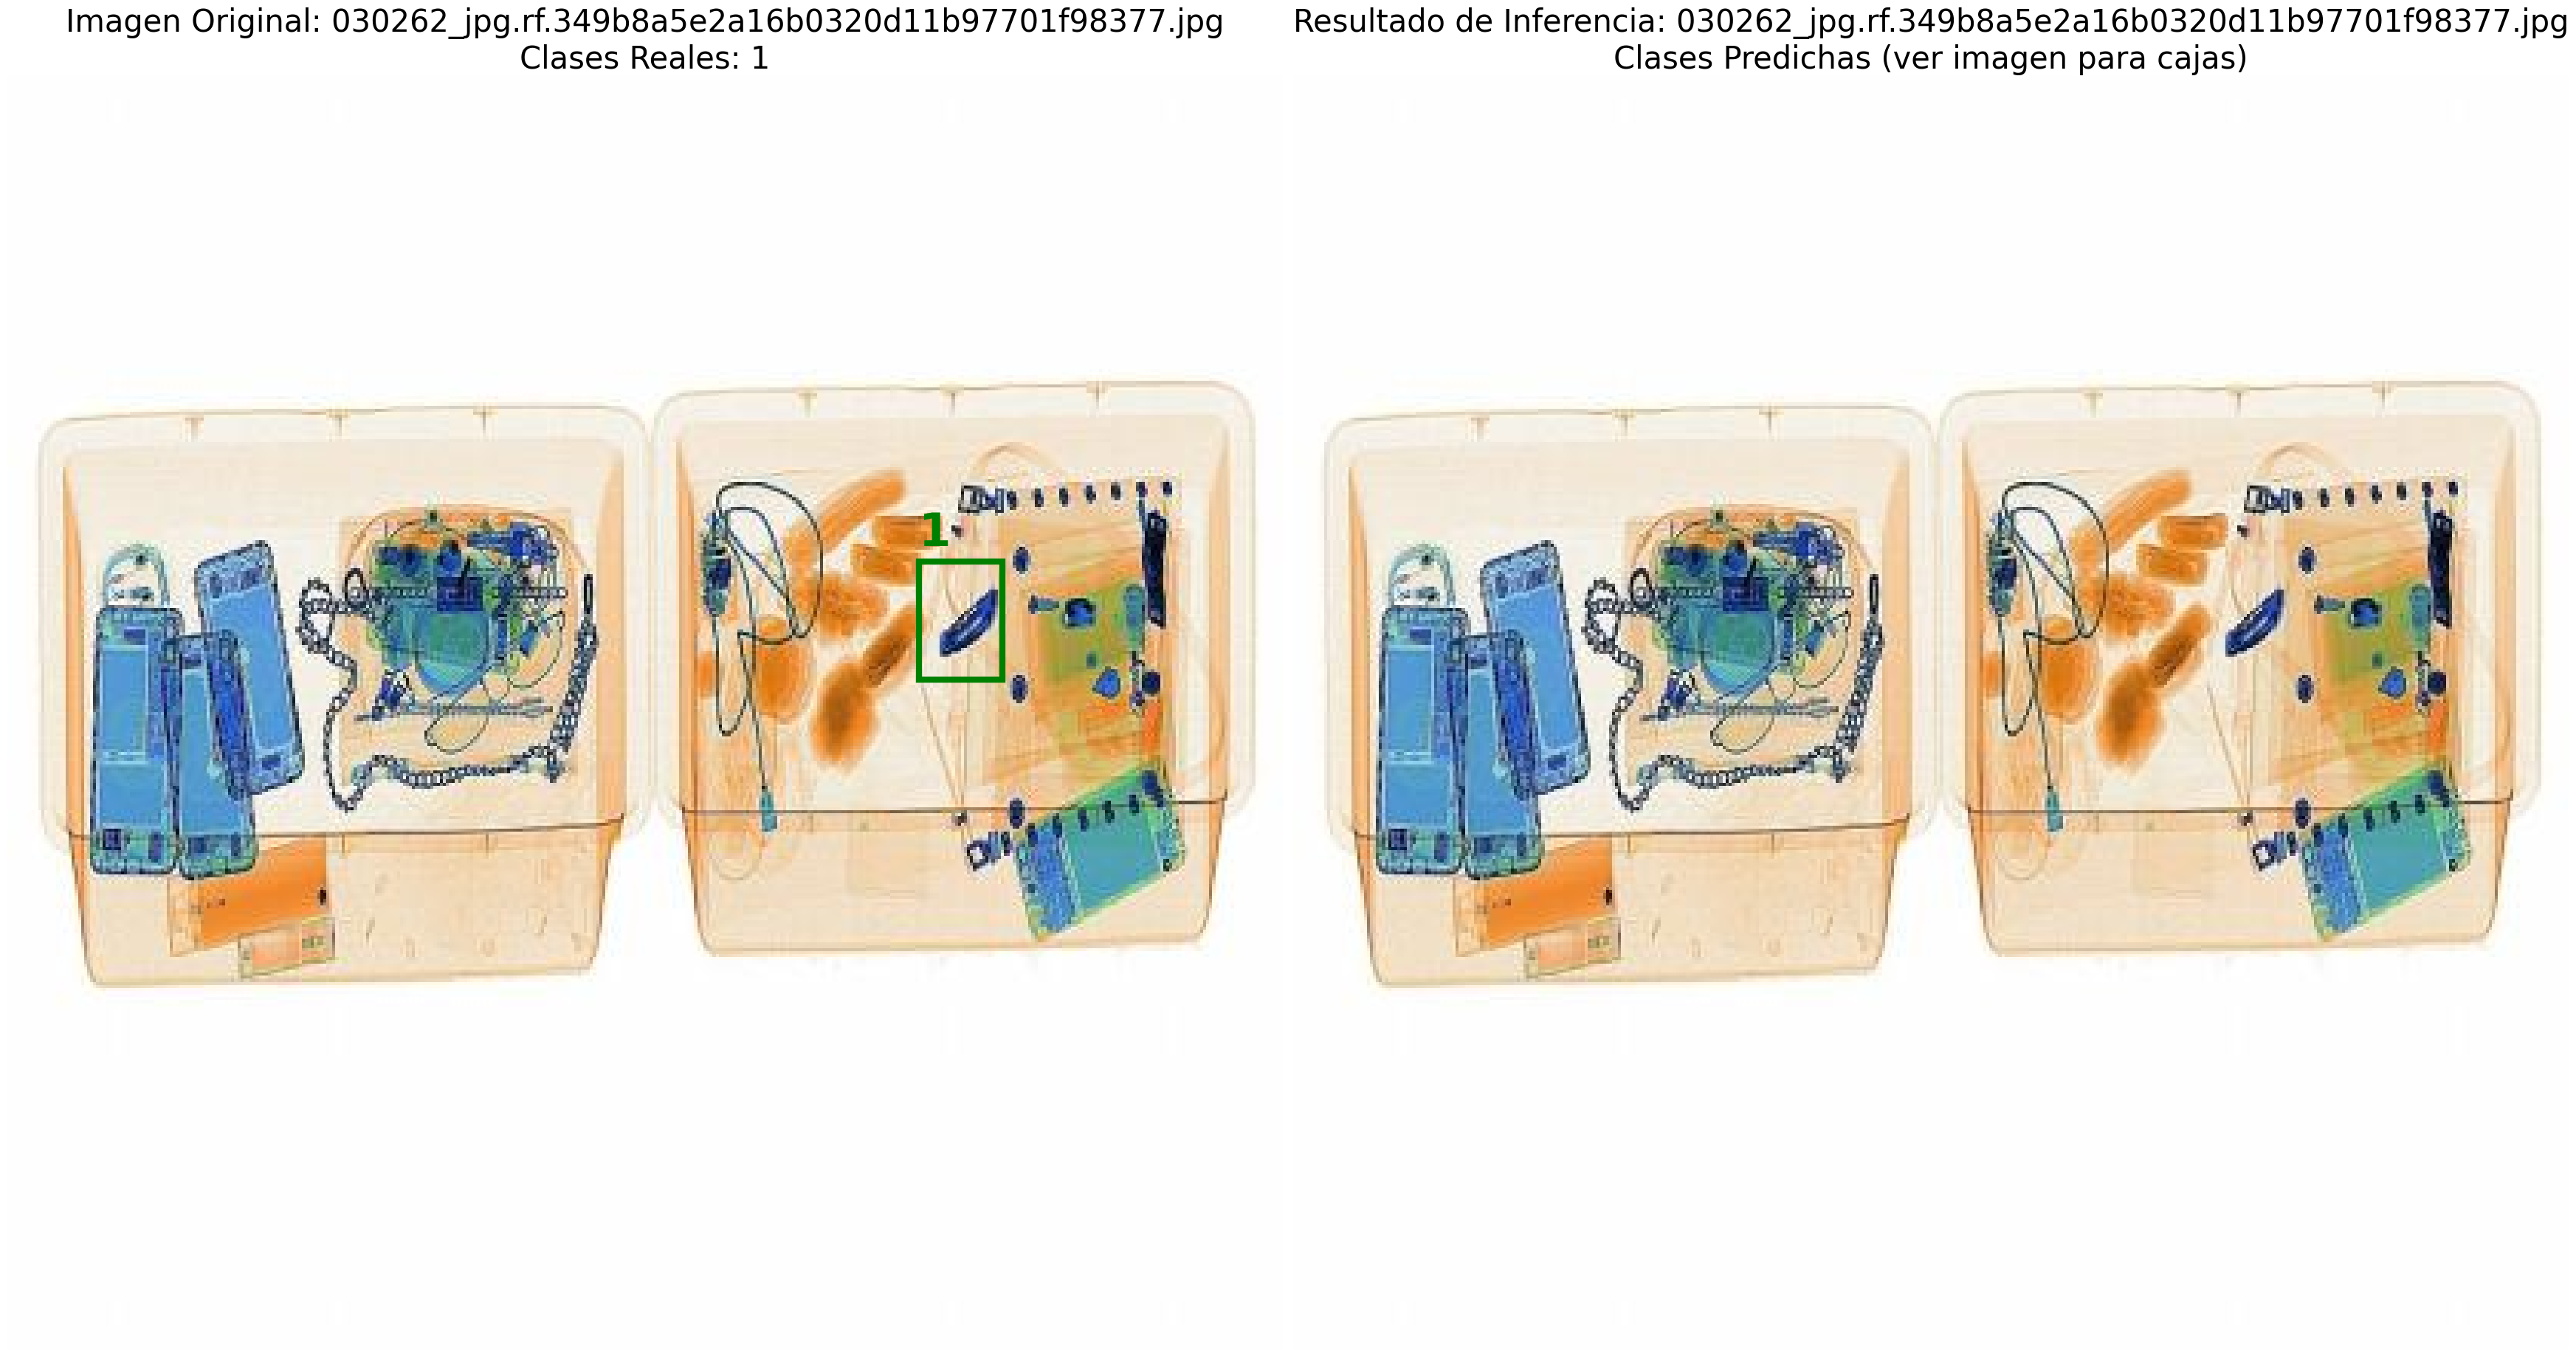

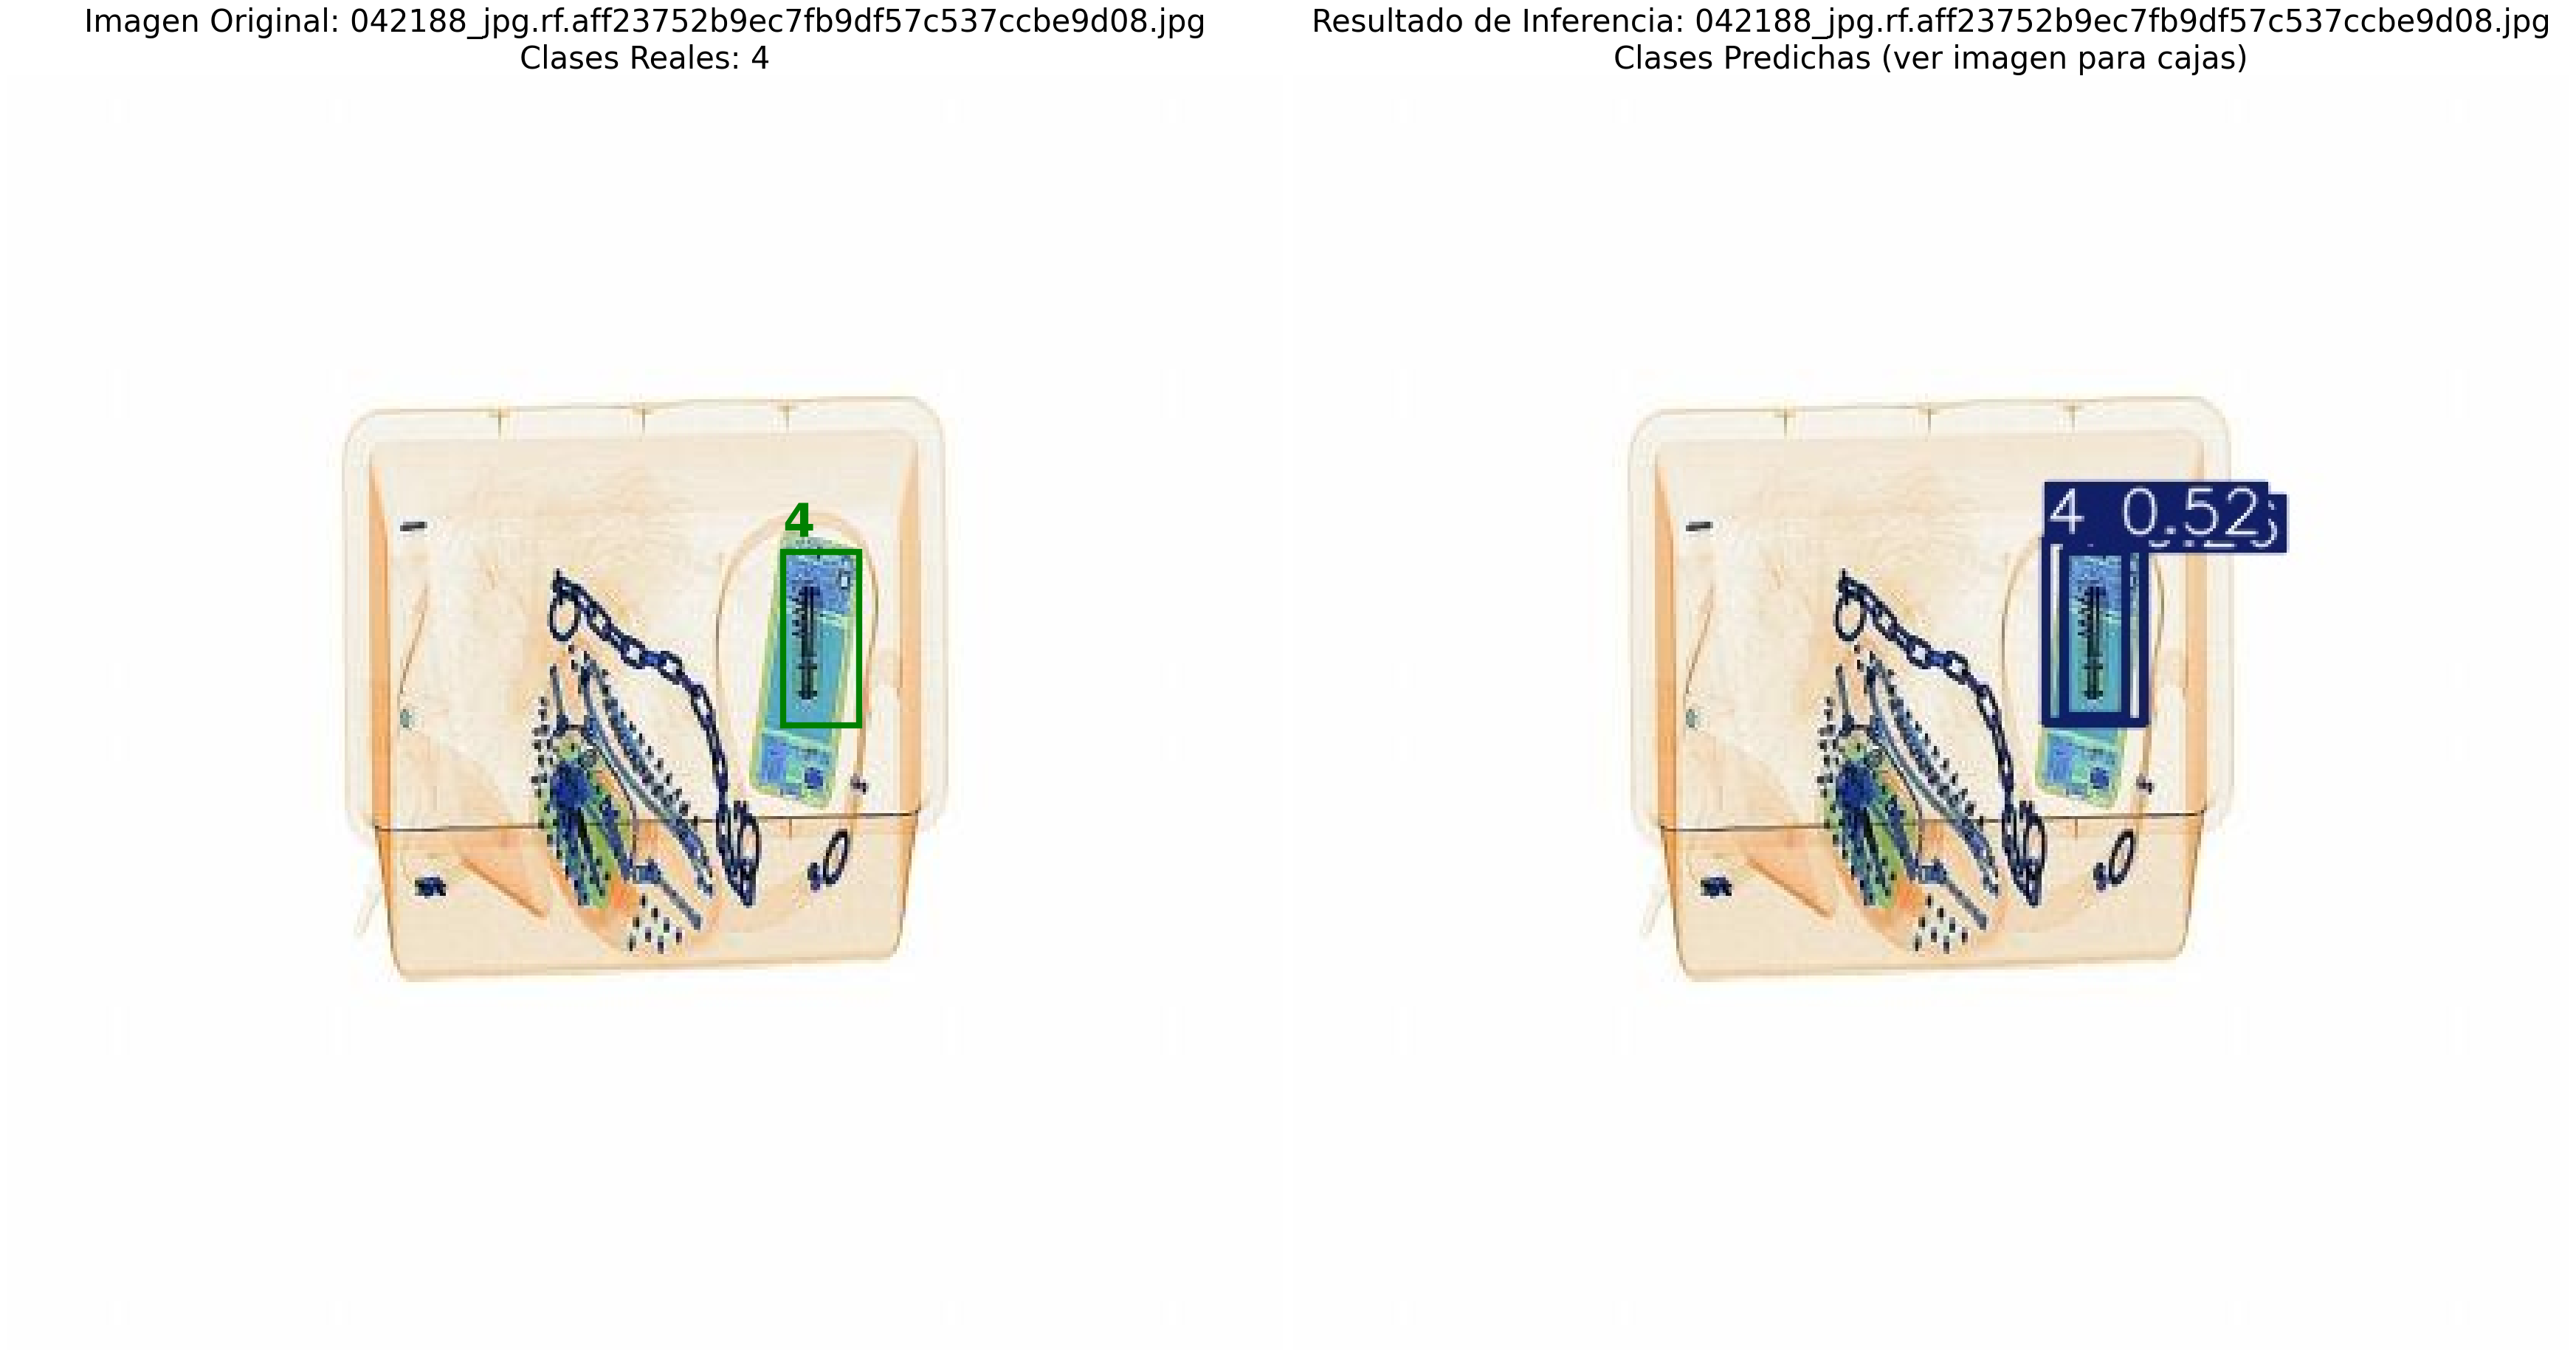

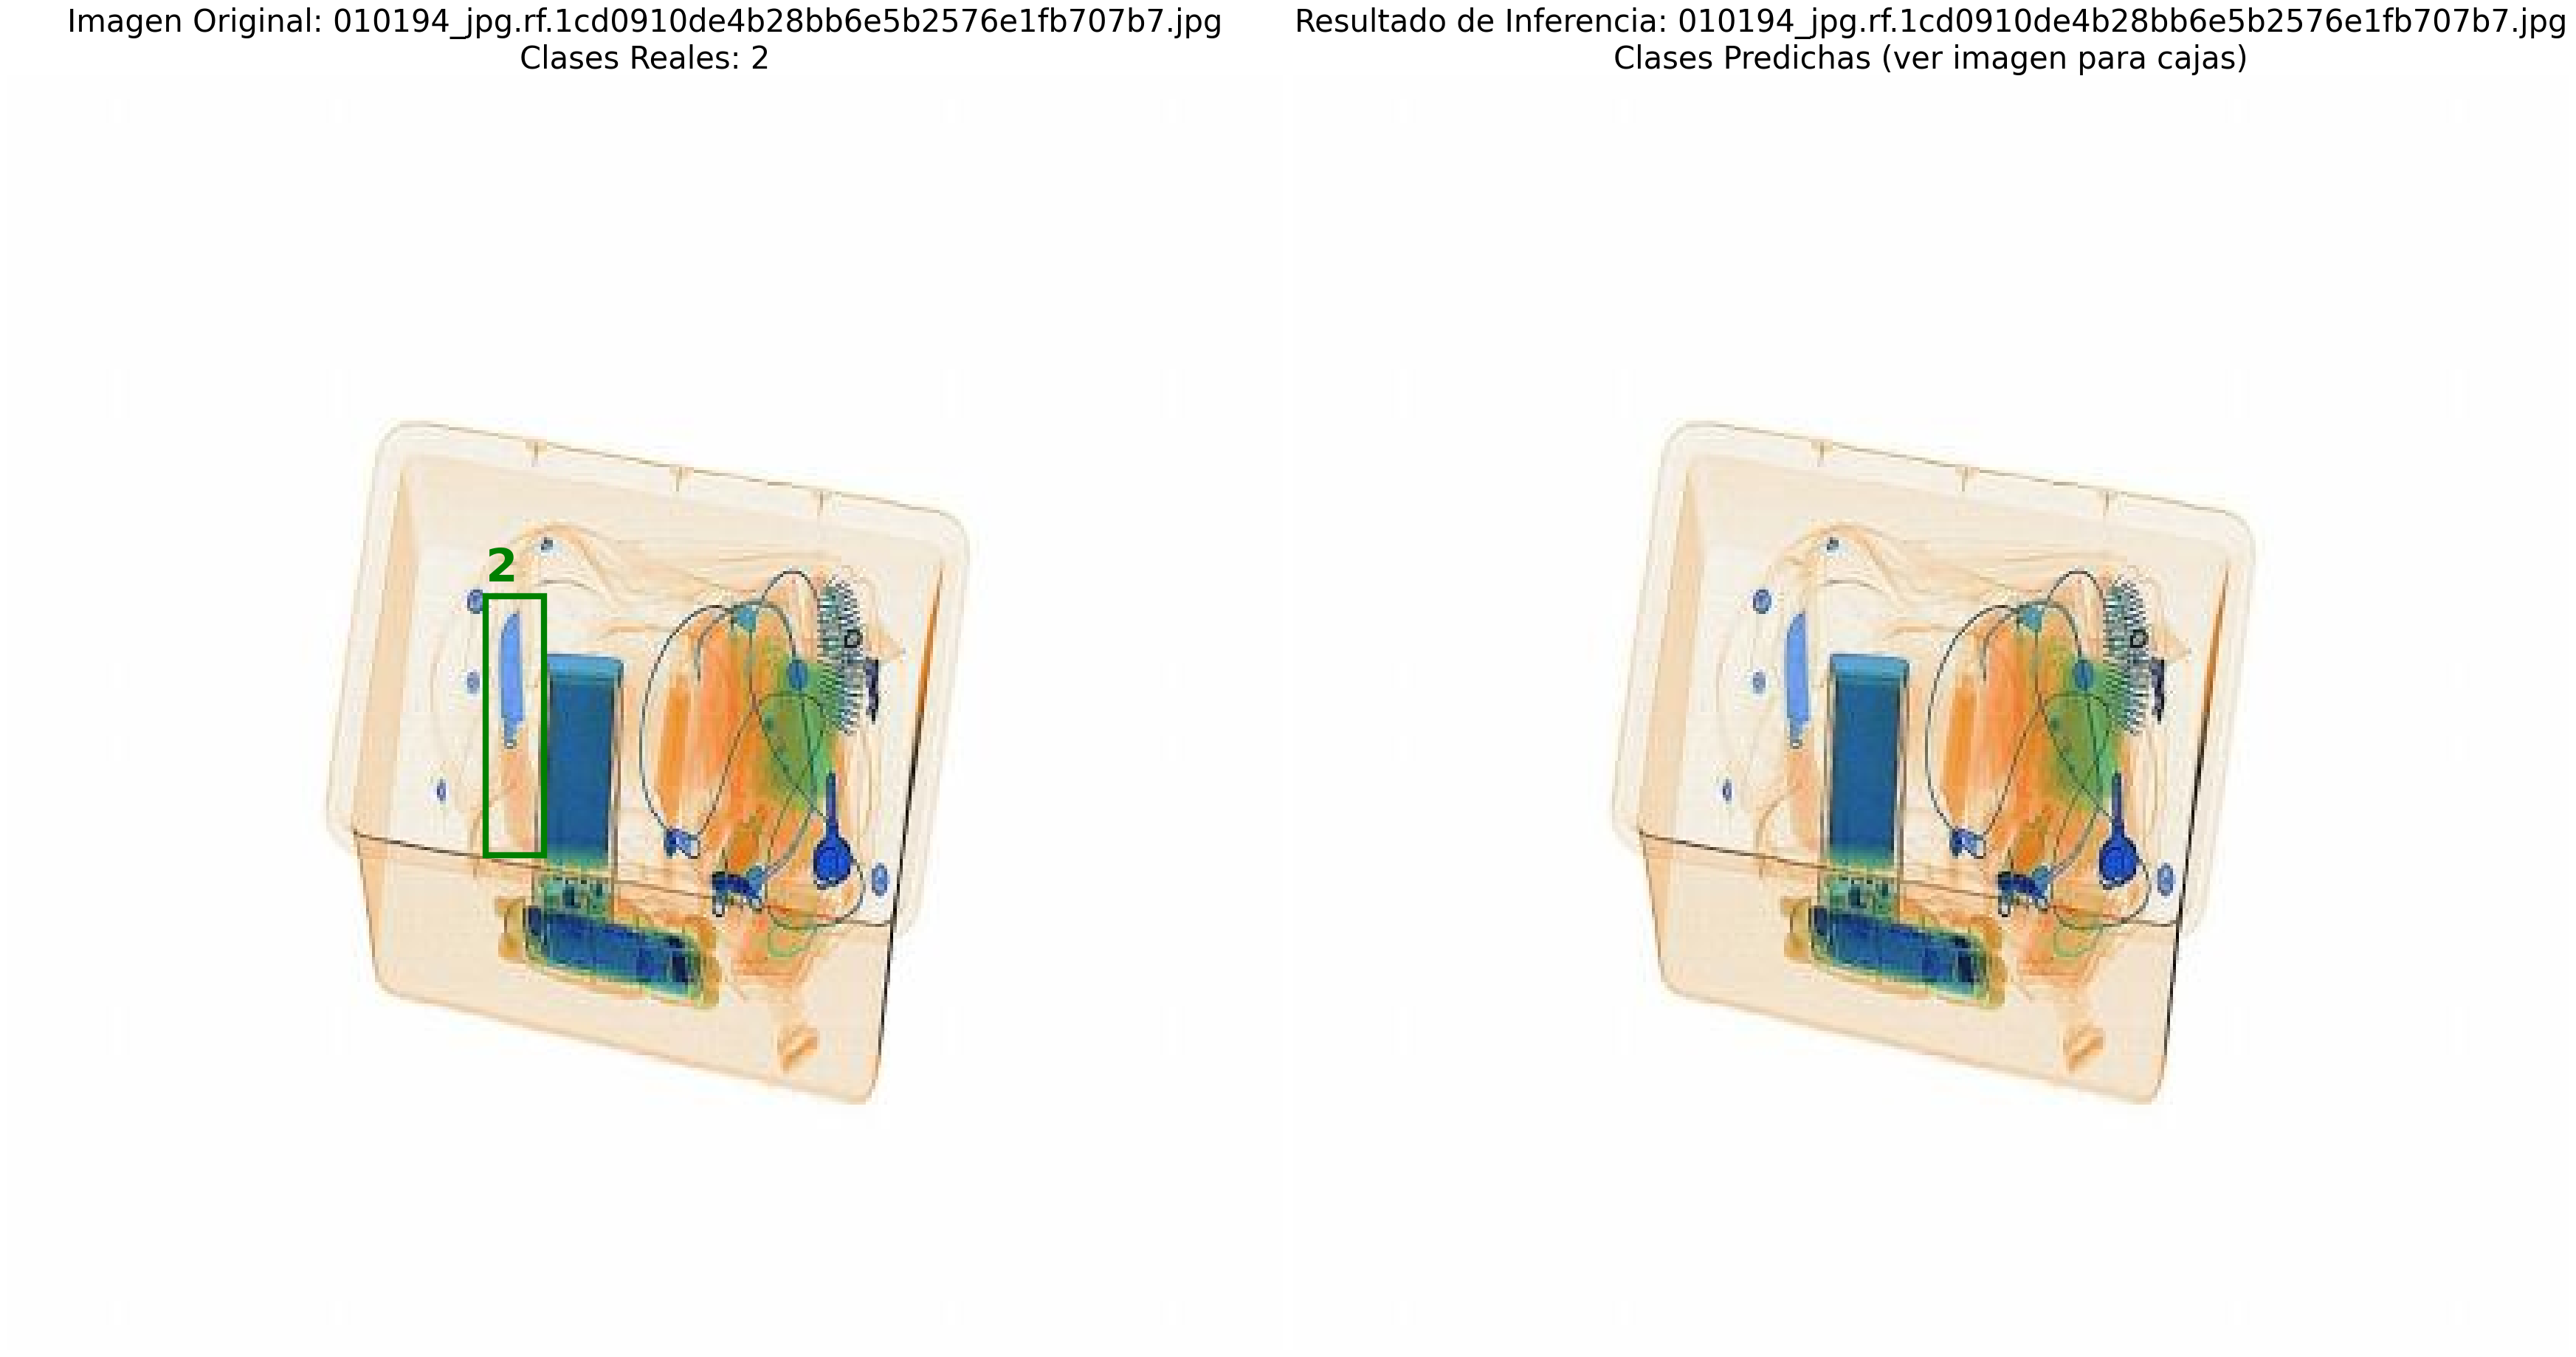

In [28]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# Definir la ruta al directorio de resultados de inferencia
inference_results_path = '/content/runs/detect/predict'

# Obtener una lista de todos los archivos de imagen dentro del directorio de resultados de inferencia
all_image_files = [f for f in os.listdir(inference_results_path) if f.endswith('.jpg') or f.endswith('.png')]

# Seleccionar algunas imágenes aleatorias para mostrar
num_images_to_display = 5  # Puedes cambiar este número
selected_image_files = random.sample(all_image_files, min(num_images_to_display, len(all_image_files)))

# Definir la ruta a las imágenes y etiquetas originales
original_images_path = os.path.join(base_path, "test", "images")
original_labels_path = os.path.join(base_path, "test", "labels")


# Iterar sobre las imágenes seleccionadas y mostrarlas lado a lado
for img_file in selected_image_files:
    original_img_path = os.path.join(original_images_path, img_file)
    inference_img_path = os.path.join(inference_results_path, img_file)
    original_label_path = os.path.join(original_labels_path, img_file.replace(".jpg", ".txt"))

    # Abrir imágenes originales e inferidas
    original_img = Image.open(original_img_path).convert("RGB")
    inference_img = Image.open(inference_img_path).convert("RGB")

    w, h = original_img.size

    # Crear subgráficos para las imágenes original e inferida
    fig, axes = plt.subplots(1, 2, figsize=(35, 35))

    # Mostrar imagen original con etiquetas reales
    ax1 = axes[0]
    ax1.imshow(original_img)
    ax1.set_title(f"Imagen Original: {img_file}\nClases Reales:", fontsize=12)
    ax1.axis('off')

    # Cargar y dibujar las etiquetas YOLO reales
    real_classes_in_image = []
    if os.path.exists(original_label_path):
        with open(original_label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls = int(parts[0])
                real_classes_in_image.append(classes[cls])
                x, y, bw, bh = map(float, parts[1:])

                # Convertir coordenadas YOLO a píxeles
                x_center, y_center = x * w, y * h
                bw, bh = bw * w, bh * h
                x1 = x_center - bw/2
                y1 = y_center - bh/2

                # Dibujar rectángulo
                rect = patches.Rectangle((x1, y1), bw, bh, linewidth=6,
                                         edgecolor="green", facecolor="none")
                ax1.add_patch(rect)
                ax1.text(x1, y1-5, classes[cls], color="green", fontsize=45, weight="bold")

    ax1.set_title(f"Imagen Original: {img_file}\nClases Reales: {', '.join(real_classes_in_image)}", fontsize=30)

    # Mostrar imagen de inferencia con predicciones
    ax2 = axes[1]
    ax2.imshow(inference_img)
    ax2.set_title(f"Resultado de Inferencia: {img_file}\nClases Predichas:", fontsize=30)
    ax2.axis('off')

    # Para obtener las clases predichas, normalmente se parsea el objeto de resultados de inferencia (inference_results).
    # Sin embargo, acceder directamente a las cajas y clases predichas desde la imagen guardada no es tan sencillo.
    # Para simplificar, se asume que los resultados de inferencia ya dibujaron las cajas en la imagen.
    # Para obtener las clases predichas de forma precisa, deberías iterar sobre el objeto 'inference_results'
    # y buscar las predicciones correspondientes al 'img_file' actual.
    # Este paso requiere un parseo más complejo de la estructura de 'inference_results'.
    # Como marcador de posición, se indica dónde se mostrarían las clases predichas.

    # Marcador de posición para las clases predichas - aquí se deberían extraer de inference_results
    # predicted_classes_in_image = []
    # Agregar código aquí para extraer las clases predichas del archivo de resultados para la imagen actual
    # ax2.set_title(f"Resultado de Inferencia: {img_file}\nClases Predichas: {', '.join(predicted_classes_in_image)}", fontsize=12)
    ax2.set_title(f"Resultado de Inferencia: {img_file}\nClases Predichas (ver imagen para cajas)", fontsize=30)

    plt.tight_layout()
    plt.show()

Implementamos y entrenamos un modelo YOLOv8n utilizando este dataset. Los resultados iniciales del entrenamiento, evaluados en el conjunto de validación, muestran un rendimiento moderado. Si bien el modelo logra un mAP50 de 0.5878, lo que indica una capacidad razonable para detectar y localizar objetos con una superposición del 50%, el mAP50-95 de 0.2315 sugiere que la precisión en la localización exacta de las bounding boxes con umbrales de IoU más altos es un desafío. Las métricas de Precisión (0.563) y Recall (0.577) globales confirman que el modelo detecta poco más de la mitad de los objetos reales con una precisión similar en sus predicciones.

La visualización de los resultados de la inferencia en imágenes de prueba nos permitió ver cómo el modelo aplica las bounding boxes predichas. Aunque no pudimos mostrar directamente las clases predichas en la visualización actual sin un parseo adicional de los resultados, la comparación visual lado a lado entre las imágenes originales con etiquetas reales y las imágenes con predicciones guardadas es un buen indicador cualitativo del rendimiento del modelo.

En conclusión, el modelo YOLOv8n ha aprendido a identificar y localizar anomalías en las imágenes de rayos X, pero existe un potencial significativo para mejorar su precisión, particularmente en la localización precisa de los objetos detectados. Próximos pasos podrían incluir la experimentación con diferentes hiperparámetros de entrenamiento, el uso de modelos YOLOv8 de mayor tamaño, o técnicas de aumento de datos más avanzadas para mejorar el rendimiento general y la precisión de las bounding boxes. Este análisis inicial proporciona una base sólida para futuras iteraciones y optimizaciones del modelo.